In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Plot issues
plt.style.use('seaborn-darkgrid')
plt.rcParams["figure.dpi"] = 140 #pixels density
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Import data

In [6]:
df = pd.read_csv('sales_irvea.csv', index_col = 'time',parse_dates=True)
df = df[df.index>='2012-06-01'] #discard the first 06 months
columns = df.columns #store them for later use
df.head()

,store13,store14,store15,store16,store17,store18,store19,store20,store21,store22,...,store54,store58,store60,store61,store62,store63,store65,store67,store68,store69
time,,,,,,,,,,,,,,,,,,,,,
2012-06-01,7015.168767,5676.377009,8671.276609,9011.954326,21414.724046,6795.639651,5819.512279,8785.692073,8260.018196,6854.919496,...,7158.501987,4965.856301,6022.617188,4941.607394,3728.123797,8740.222070,3692.286876,4130.216352,9663.432501,5945.184433
2012-06-02,4768.165912,3535.258705,6213.870916,5781.196069,12198.903950,4224.933537,4448.545540,6039.165507,5441.620365,4567.254732,...,6990.435130,5811.809071,7568.706301,4496.708045,4284.170906,8651.528773,3700.550728,4866.107254,8355.761882,6866.389090
2012-06-03,4771.792128,4164.945414,6550.104945,5274.423859,16325.559316,5801.884863,4825.744547,8479.882617,6088.373928,5042.529135,...,7389.523546,5713.973129,5001.813652,5115.167917,3888.687505,7774.030249,2885.066459,4459.747891,6325.037280,7295.590551
2012-06-04,6011.455266,4366.143498,7910.665980,8739.123396,9144.641395,6015.090158,4663.602271,7194.342313,6619.647076,6533.590832,...,5986.759244,4933.044339,6245.416109,5146.765698,3546.469802,7703.446362,3761.212704,3801.667251,6953.042070,7378.720654
2012-06-05,5894.697806,4183.989200,8121.408585,8000.894621,9957.540004,5344.818375,3972.374226,6489.767352,6763.940927,6366.083785,...,4757.981699,4522.944027,5719.615053,4329.562710,3163.985592,6250.884899,2611.413005,3485.057050,6152.748632,5654.881146


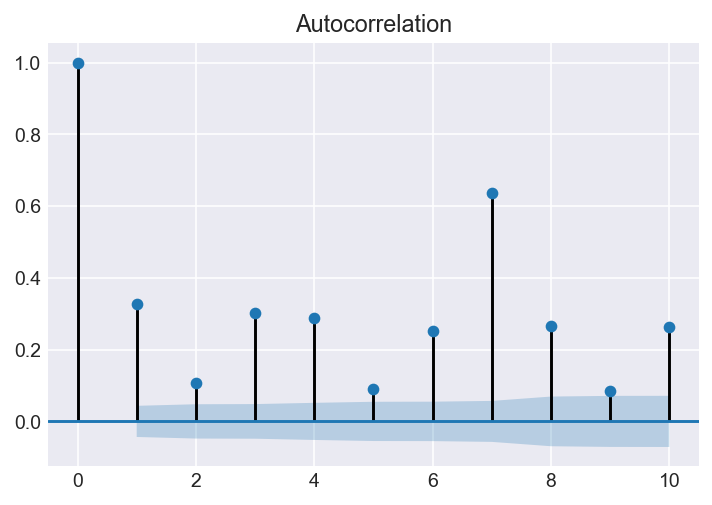

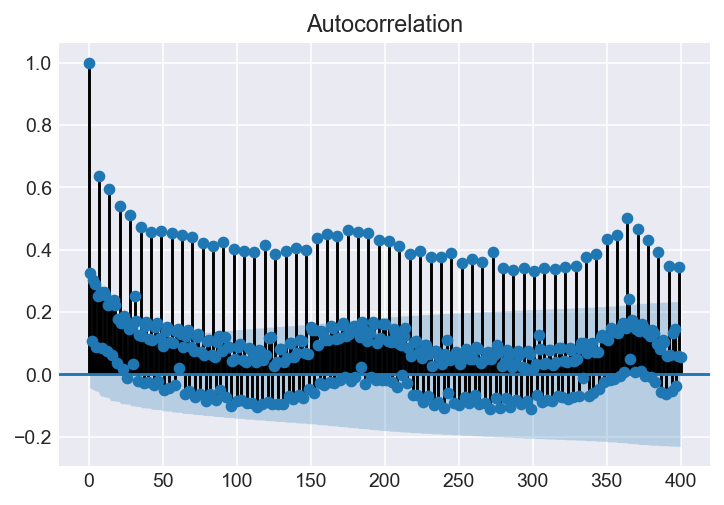

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(df.store13,lags = 10);
plot_acf(df.store13,lags = 400);

## Features preparation

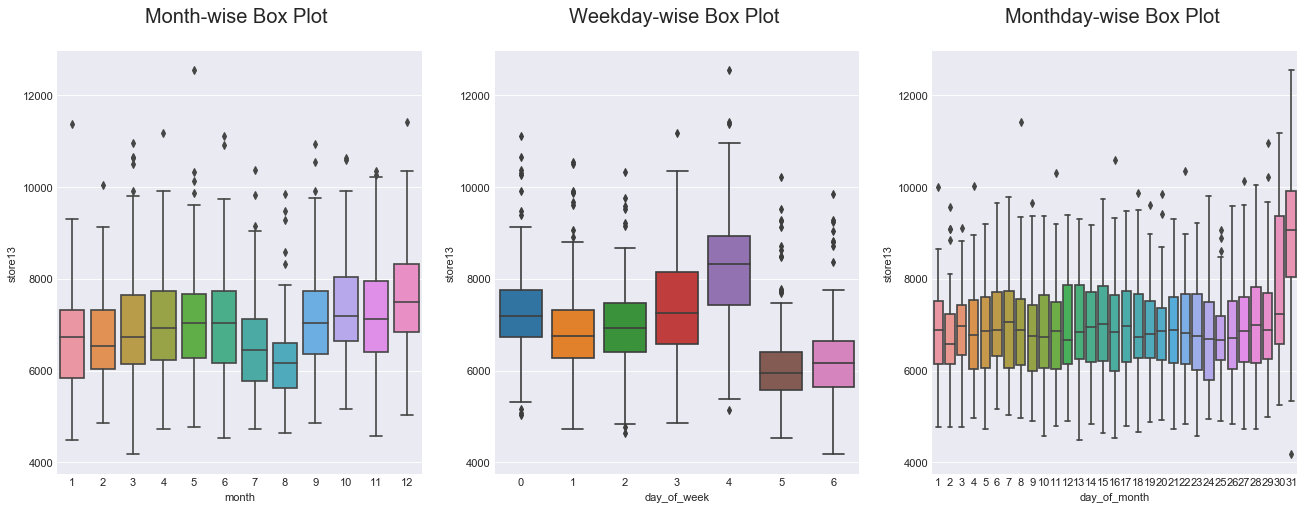

In [8]:
# Prepare features
df['year'] = [d.year for d in df.index]
df['month'] = [d.month for d in df.index]
df['day_of_week'] = [d.weekday() for d in df.index]
df['day_of_month'] = [d.day for d in df.index]

# Draw Plot
fig, axes = plt.subplots(1, 3, figsize=(20,7), dpi= 80)
#sns.boxplot(x='year', y='store13', data=df, ax=axes[0])
sns.boxplot(x='month', y='store13', data=df, ax=axes[0])
sns.boxplot(x='day_of_week', y='store13', data=df, ax=axes[1])
sns.boxplot(x='day_of_month', y='store13', data=df, ax=axes[2])

# Set Title
#axes[0].set_title('Year-wise Box Plot\n(The Trend)', fontsize=18); 
axes[0].set_title('Month-wise Box Plot \n', fontsize=18)
axes[1].set_title('Weekday-wise Box Plot \n', fontsize=18)
axes[2].set_title('Monthday-wise Box Plot \n', fontsize=18)
plt.show()

In [9]:
# dummy variable for holiday
import holidays
from datetime import datetime, timedelta


from sklearn import preprocessing
le = preprocessing.LabelEncoder()


GH = holidays.France()

df['holiday'] = 0

for date in df.index:
    if date in GH:
        #df.loc[date,'holiday'] = GH[datetime.fromtimestamp(date.timestamp())]
        df.loc[date,'holiday'] = 1
        #df.loc[date - timedelta(days=1)] = 2
        #df.loc[date + timedelta(days=1)] = 3
        


#df.holiday = le.fit_transform(list(df.holiday.values))


print("Number of holidays : {}".format(len(df)-len(df[df.holiday==0])))

Number of holidays : 60


# Random Forest (exogeneous features)

In [10]:
# metric used for evaluation
def MARE (y_true,y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true-y_pred)/y_true))*100

In [11]:
from sklearn.model_selection import TimeSeriesSplit #Time series cross-validation
from sklearn.ensemble import RandomForestRegressor

X = df[['day_of_week','month','day_of_month','holiday']].values
y = df[columns].values

tscv = TimeSeriesSplit(n_splits=10)

regressor = RandomForestRegressor(n_estimators=50, random_state=0)

scores = []

for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        regressor.fit(X_train,y_train);
        scores.append(MARE(y_test,regressor.predict(X_test)))

print(np.mean(scores))

11.603743015621292


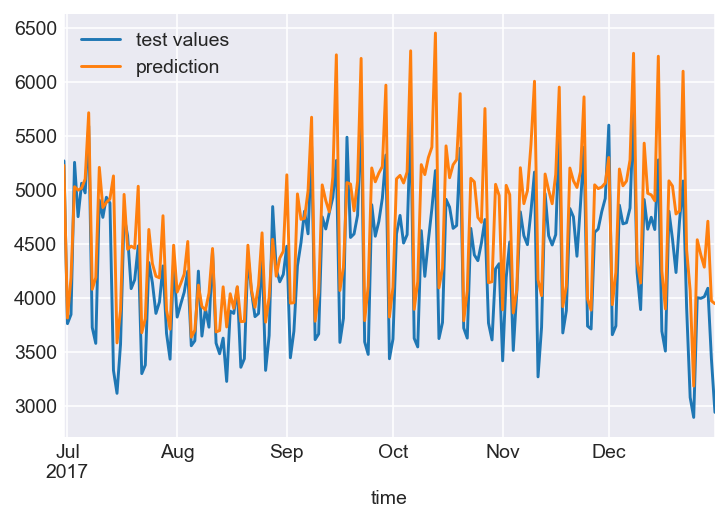

In [57]:
# plot prediction result for specific store
store = 20 #store number
pd.DataFrame(np.vstack((y_test[:,store],regressor.predict(X_test)[:,store])).T,\
            index= df.index[test_index],columns=['test values','prediction']).plot();

plt.legend(loc='upper left');

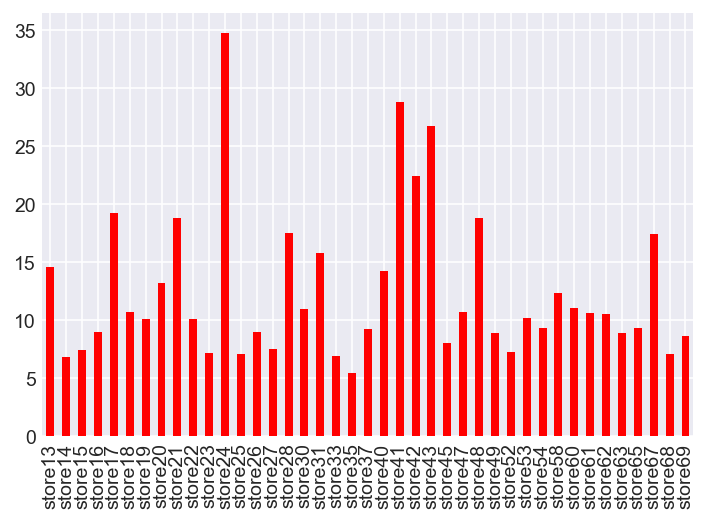

In [59]:
s = pd.Series([MARE(y_test[:,i],regressor.predict(X_test)[:,i]) for i in range(41)])
s.index = columns
plt.rcParams["figure.dpi"] = 140 #pixels density
s.plot.bar(color='r');

# Random forest with lagged variables

In [ ]:
X_in = pd.concat([df[columns].rolling(7).mean(),\
df[columns].rolling(30).mean(),\
df[columns].rolling(364).mean(),\
df[columns].shift(1),\
df[columns].shift(2),\
df[columns].shift(3),\
df[columns].shift(4),\
df[columns].shift(5),\
df[columns].shift(6),\
df[columns].shift(7),\
df[columns].shift(364)],axis=1).dropna()

X_ex = df[['day_of_week','month','day_of_month','holiday']].loc[X_in.index]

X = pd.concat([X_in,X_ex],axis=1).values

y = df[columns].loc[X_in.index].values

tscv = TimeSeriesSplit(n_splits=10)

regressor = RandomForestRegressor(n_estimators=50, random_state=0)

scores = []

for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        regressor.fit(X_train,y_train);
        scores.append(MARE(y_test,regressor.predict(X_test)))

print(np.mean(scores))

# Random forests with independent lagged variables

In [12]:
tscv = TimeSeriesSplit(n_splits=10)

regressor = RandomForestRegressor(n_estimators=50, random_state=0)

all_scores = []

for column in columns:
    
    X_in = pd.concat([df[column].rolling(7).mean(),\
    df[column].rolling(30).mean(),\
    df[column].rolling(364).mean(),\
    df[column].shift(1),\
    df[column].shift(2),\
    df[column].shift(3),\
    df[column].shift(4),\
    df[column].shift(5),\
    df[column].shift(6),\
    df[column].shift(7),\
    df[column].shift(364)],axis=1).dropna()

    X_ex = df[['day_of_week','month','day_of_month','holiday']].loc[X_in.index]

    X = pd.concat([X_in,X_ex],axis=1).values

    y = df[column].loc[X_in.index].values
    
    scores = []

    for train_index, test_index in tscv.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            regressor.fit(X_train,y_train);
            scores.append(MARE(y_test,regressor.predict(X_test)))

    all_scores.append(scores)
    
print(np.mean(all_scores))

7.798921176172386


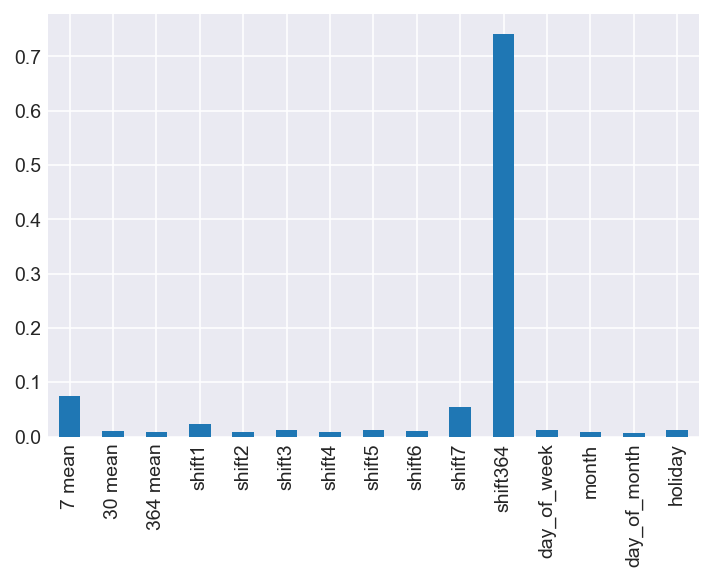

In [44]:
features = ['7 mean','30 mean','364 mean'] +\
['shift'+str(i) for i in [1,2,3,4,5,6,7,364]] +\
['day_of_week','month','day_of_month','holiday']
s = pd.Series(regressor.feature_importances_)
s.index = features
s.plot.bar();

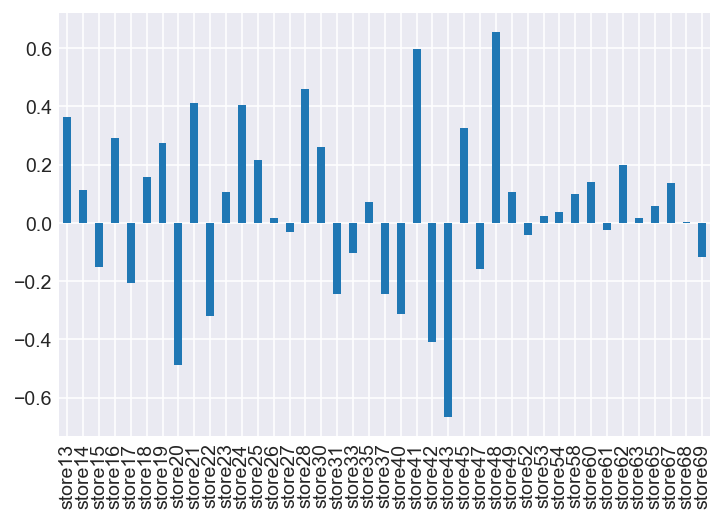

In [45]:
corr = df.corr()
#plt.rcParams["figure.dpi"] = 140 #pixels density
corr.year.iloc[:-5].plot.bar();

# Linear regression exogenous features

In [14]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge


X_df = pd.get_dummies(df[['day_of_week','month','day_of_month']].applymap(str))
X_df['holiday']=df['holiday']                         
X_df['year'] = df['year'] #year variable is not treated as categorical: it's not one-hot encoded
X = PolynomialFeatures(degree=2, interaction_only=False,include_bias=True).fit_transform(X_df)
#X = X_df.values
y = df[columns].values


regressor = Ridge(alpha=1)
tscv = TimeSeriesSplit(n_splits=10)


scores = []

for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        regressor.fit(X_train,y_train);
        scores.append(MARE(y_test,regressor.predict(X_test)))

print(np.mean(scores))


11.8719746232763


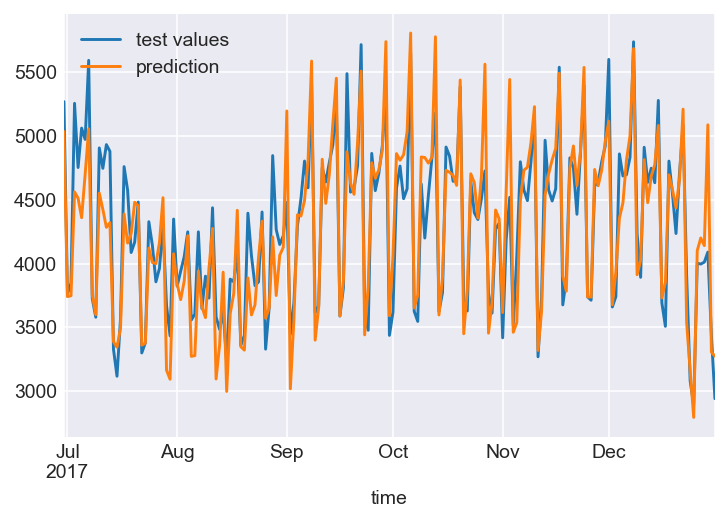

In [15]:
# plot prediction result for specific store
store = 20 #store number
pd.DataFrame(np.vstack((y_test[:,store],regressor.predict(X_test)[:,store])).T,\
            index= df.index[test_index],columns=['test values','prediction']).plot();

plt.legend(loc='upper left');

# Linear regression with lagged variables


In [16]:
X_in = pd.concat([df[columns].rolling(7).mean(),\
df[columns].rolling(30).mean(),\
df[columns].rolling(364).mean(),\
df[columns].shift(1),\
df[columns].shift(2),\
df[columns].shift(3),\
df[columns].shift(4),\
df[columns].shift(5),\
df[columns].shift(6),\
df[columns].shift(7),\
df[columns].shift(364)],axis=1).dropna()

X_ex = pd.get_dummies(df[['day_of_week','month','day_of_month']].applymap(str))
X_ex['holiday']=df['holiday']                         
X_ex['year'] = df['year'] #year variable is not treated as categorical: it's not one-hot encoded
X_ex = X_ex.loc[X_in.index]
#X_ex = PolynomialFeatures(degree=2, interaction_only=False,include_bias=True).fit_transform(X_ex)
X_ex = X_ex.values

X = np.hstack((X_ex,X_in.values))

y = df[columns].loc[X_in.index].values

tscv = TimeSeriesSplit(n_splits=10)

regressor = Ridge(alpha=1)

scores = []

for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        regressor.fit(X_train,y_train);
        scores.append(MARE(y_test,regressor.predict(X_test)))

print(np.mean(scores))

3.8945615860366813


# Linear regression with independent lagged variables

In [18]:
tscv = TimeSeriesSplit(n_splits=10)

regressor = Ridge(alpha=0.01)

all_scores = []

for column in columns:
    X_in = pd.concat([df[column].rolling(7).mean(),\
    df[column].rolling(30).mean(),\
    df[column].rolling(364).mean(),\
    df[column].shift(1),\
    df[column].shift(2),\
    df[column].shift(3),\
    df[column].shift(4),\
    df[column].shift(5),\
    df[column].shift(6),\
    df[column].shift(7),\
    df[column].shift(364)],axis=1).dropna()

    X_ex = pd.get_dummies(df[['day_of_week','month','day_of_month']].applymap(str))
    X_ex['holiday']=df['holiday']                         
    X_ex['year'] = df['year'] #year variable is not treated as categorical: it's not one-hot encoded
    X_ex = X_ex.loc[X_in.index]
    #X_ex = PolynomialFeatures(degree=2, interaction_only=False,include_bias=True).fit_transform(X_ex)
    X_ex = X_ex.values

    X = np.hstack((X_ex,X_in.values))

    y = df[column].loc[X_in.index].values

    scores = []

    for train_index, test_index in tscv.split(X):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]
            regressor.fit(X_train,y_train);
            scores.append(MARE(y_test,regressor.predict(X_test)))

    all_scores.append(scores)
    
print(np.mean(all_scores))

1.2946378194548388e-07
